# System Identification and Control Design

In [1]:
%load_ext autoreload
%autoreload 2
import px4tools
import px4tools.logsysid
import pandas
import control
import json
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = px4tools.process_data(pandas.read_csv('./sess052/log001.csv'))

fit quality 88.29 %
margins (1.8767161042952027, 64.899347002841836, 23.334730455075167, 94.394633036260032)
fit quality 87.12 %
margins (1.7485999476901406, 62.641820457281767, 23.547738032621584, 89.578743186469964)
{
    "MC_ROLLRATE_P": 0.081,
    "MC_ROLLRATE_I": 0.074,
    "MC_ROLLRATE_D": 0.002,
    "MC_PITCHRATE_P": 0.098,
    "MC_PITCHRATE_I": 0.095,
    "MC_PITCHRATE_D": 0.003
}


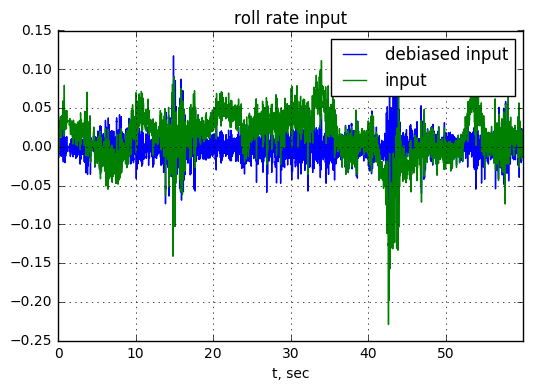

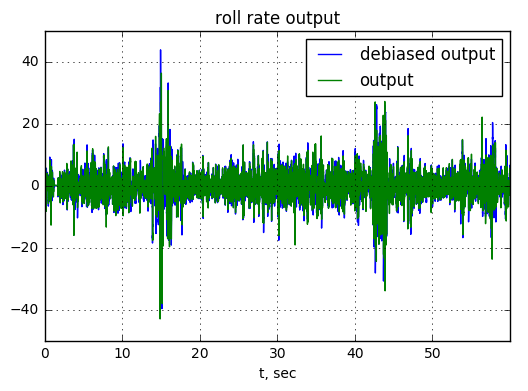

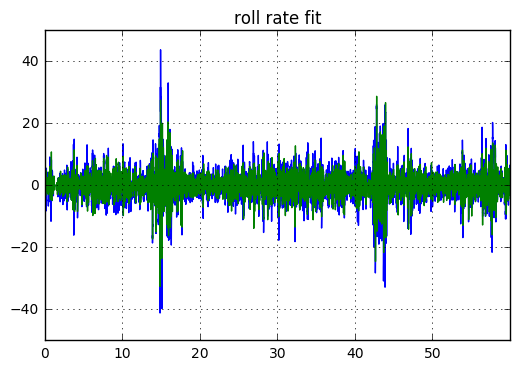

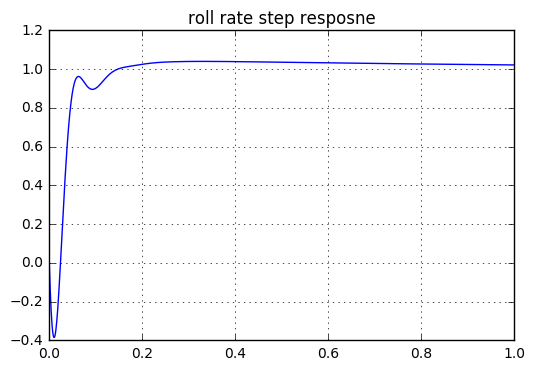

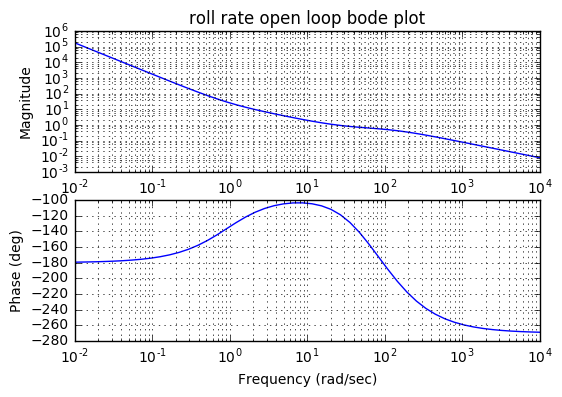

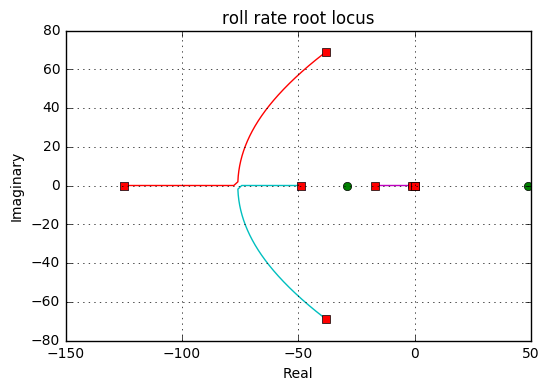

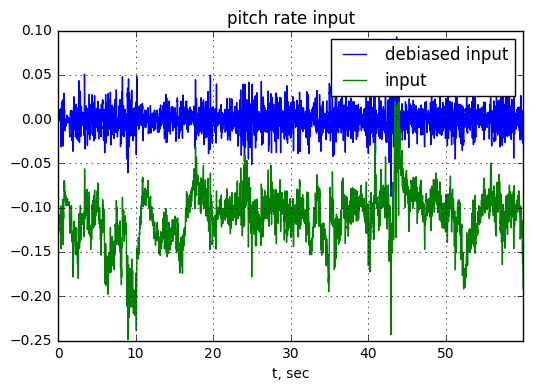

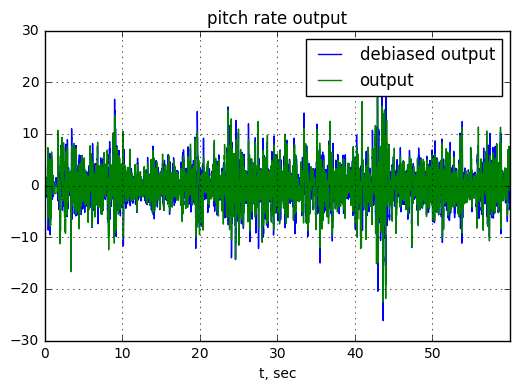

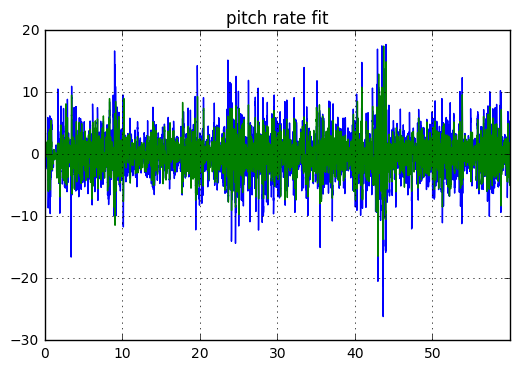

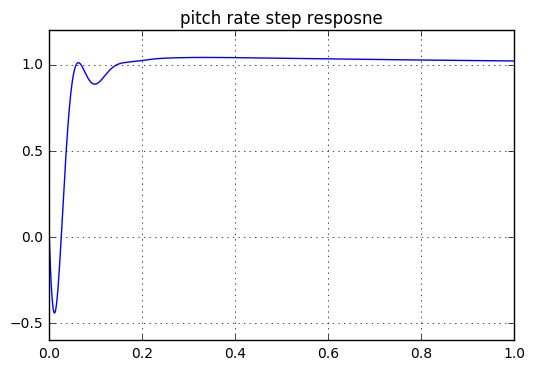

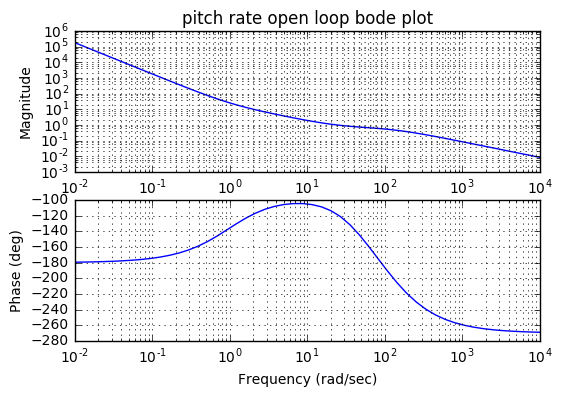

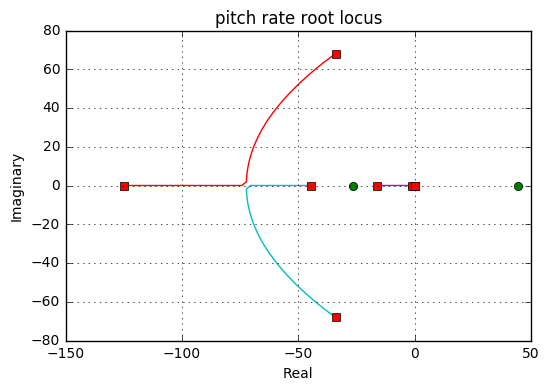

In [3]:
gains = px4tools.logsysid.control_design(data[20:80],
    do_plot=True)
print(json.dumps(gains, indent=4))